In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import wandb
from torch.utils.data import Dataset
import gzip

import glob
from glob import glob
import nibabel as nb
import imageio

from dataclasses import dataclass
from ResnetGenerator3D import ResnetGenerator3D
from NLayerDiscriminator3D import NLayerDiscriminator3D

@dataclass
class Parameters:
    bs : int
    n_channels : int
    ngf : int
    ndf : int
    size : int
    gen_n_down : int
    gen_n_blocks : int
    dis_n_down : int
    lr : float
    beta1 : float

class mriDataset(Dataset):
    def __init__(self, input_dir):
        self.mri_files = glob(input_dir+'/*/m*')
    
    def __getitem__(self,idx):
        vol = round(idx/80)
        mri_vol = gzip.GzipFile(self.mri_files[vol],'r');
        
        slice = idx-vol*80;
        mri_img = torch.from_numpy(np.load(mri_vol)[:,:,150+slice:150+slice+4])     # get slice from volume
        
        # transforms
        mri_img = mri_img + (0.001**0.5)*torch.randn(256,320,4)                     # add noise

        mri_img = torch.permute(mri_img,(2,0,1));
        mri_img = mri_img/torch.max(mri_img).item()                                 # normalize

        return mri_img
    
class sosDataset(Dataset):
    def __init__(self, input_dir):
        self.sos_files = glob(input_dir+'/*/V*')
    
    def __getitem__(self,idx):
        vol = round(idx/80)
        sos_vol = gzip.GzipFile(self.sos_files[vol],'r');
        
        slice = idx-vol*80;
        sos_img = torch.from_numpy(np.load(sos_vol)[:,:,150+slice:150+slice+4])     # get slice from volume

        # transforms
        sos_img = sos_img + (0.001**0.5)*torch.randn(256,320,4)                     # add noise

        sos_img = torch.permute(sos_img,(2,0,1));
        sos_img = sos_img/torch.max(sos_img).item()                                 # normalize

        return sos_img


def init_dataset(bs, test=False):
    if(test == False): path = '../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/train';
    if(test == True): path = '../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/test';
    dataloader_mri = mriDataset(path);
    dataloader_sos = sosDataset(path);
    
    return dataloader_mri, dataloader_sos

def init_models(p):
    G_A2B = ResnetGenerator3D(input_nc=1,output_nc=1,ngf=12,norm_layer=nn.BatchNorm3d, use_dropout=False, n_blocks=2, n_downsampling=2, padding_type='reflect')
    G_B2A = ResnetGenerator3D(input_nc=1,output_nc=1,ngf=12,norm_layer=nn.BatchNorm3d, use_dropout=False, n_blocks=2, n_downsampling=2, padding_type='reflect')
    D_A = NLayerDiscriminator3D(input_nc=1,ndf=64,n_layers=2, norm_layer=nn.BatchNorm3d)
    D_B = NLayerDiscriminator3D(input_nc=1,ndf=64,n_layers=2, norm_layer=nn.BatchNorm3d)

    optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
    optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

    optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
    optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

    return G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))
def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

def plot_images_test(iter_mri_test, iter_sos_test, epoch): 
    batch_a_test = next(iter_mri_test).unsqueeze(0).unsqueeze(0).float().to(device)
    real_a_test = G_A2B(batch_a_test).cpu().detach()
    fake_b_test = G_A2B(batch_a_test).cpu().detach()

    batch_b_test = next(iter_sos_test).unsqueeze(0).unsqueeze(0).float().to(device)
    real_b_test = G_B2A(batch_b_test).cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()

    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()

    fake_a_error = (real_a_test - fake_a_test)[0,0,:,:]
    fake_b_error = (real_b_test - fake_b_test)[0,0,:,:]

    plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.imshow(fake_a_error[0,:,:],cmap='PiYG'); plt.colorbar()
    plt.clim(-1,1)
    plt.title('Fake MRI MAE')
    plt.subplot(1,2,2)
    plt.imshow(fake_b_error[0,:,:],cmap='PiYG'); plt.colorbar()
    plt.clim(-1,1)
    plt.title('Fake SoS MAE')
    # plt.show(block=False)
    # plt.savefig('home/Documents/Scripts/3d_cycleGAN/Images/training_'+name+'err_epoch'+str(epoch)+'.png')
    plt.savefig('Images/3D/err_epoch'+str(epoch)+'.png')
    

def save_models(G_A2B, G_B2A, D_A, D_B, name):
  torch.save(G_A2B, name+"_G_A2B_3d.pt")
  torch.save(G_B2A,  name+"_G_B2A_3d.pt")
  torch.save(D_A,  name+"_D_A_3d.pt")
  torch.save(D_B, name+"_D_B_3d.pt")
def load_models( name):
  G_A2B=torch.load(name+'_G_A2B_3d.pt', map_location=torch.device('cpu'))
  G_B2A=torch.load(name+"_G_B2A_3d.pt",map_location=torch.device('cpu'))
  D_A=torch.load(name+"_D_A_3d.pt", map_location=torch.device('cpu'))
  D_B=torch.load(name+"_D_B_3d.pt", map_location=torch.device('cpu'))
  return G_A2B, G_B2A, D_A, D_B 

In [2]:
dataloader_mri, dataloader_sos = init_dataset(1, False)                                                                                     # dataloader for train images
test_dataloader_mri, test_dataloader_sos = init_dataset(1, True)                                                                            # dataloader for test images
iter_mri = iter(dataloader_mri);
iter_sos = iter(dataloader_sos);
iter_mri_test = iter(dataloader_mri);
iter_sos_test = iter(dataloader_sos);

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_A2B, G_B2A, D_A, D_B  = load_models('230328');
G_A2B.to(device);
G_B2A.to(device);
D_A.to(device);
D_B.to(device);

In [4]:
a_real = next(iter_mri).unsqueeze(0).unsqueeze(0).float().to(device)
b_real = next(iter_sos).unsqueeze(0).unsqueeze(0).float().to(device)

# Generate images
b_fake = G_A2B(a_real)
a_rec = G_B2A(b_fake)
a_fake = G_B2A(b_real)
b_rec = G_A2B(a_fake)

In [5]:
# remove all from gpu
a_real=a_real.detach().cpu();
b_real=b_real.detach().cpu();
b_fake=b_fake.detach().cpu();
a_rec=a_rec.detach().cpu();
a_fake=a_fake.detach().cpu();
b_rec=b_rec.detach().cpu();

Text(0.5, 1.0, 'Rec MRI')

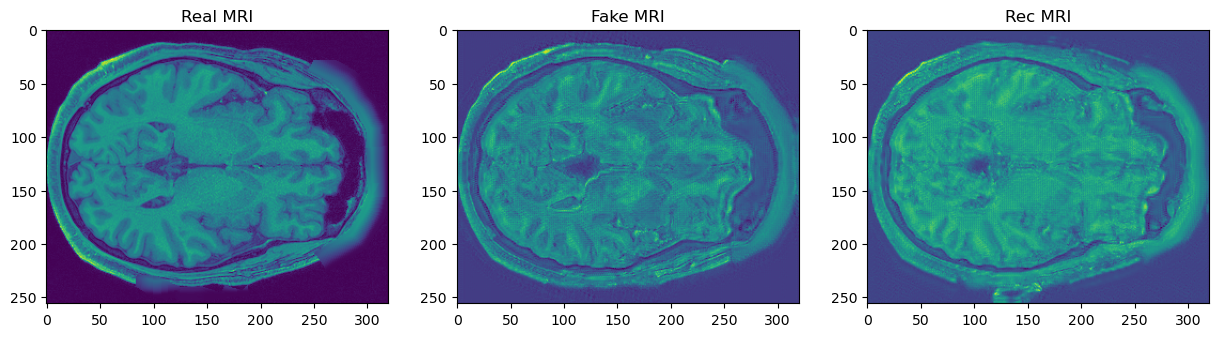

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(a_real[0,0,3,:,:]);plt.title('Real MRI');
plt.subplot(1,3,2)
plt.imshow(a_fake[0,0,3,:,:]);plt.title('Fake MRI')
plt.subplot(1,3,3)
plt.imshow(a_rec[0,0,3,:,:]);plt.title('Rec MRI')

Text(0.5, 1.0, 'Rec SoS')

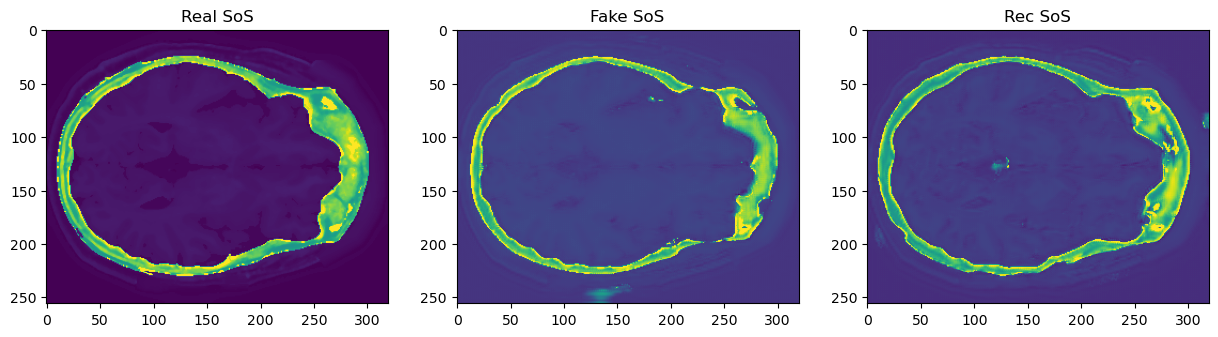

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(b_real[0,0,3,:,:]);plt.title('Real SoS');
plt.subplot(1,3,2)
plt.imshow(b_fake[0,0,3,:,:]);plt.title('Fake SoS')
plt.subplot(1,3,3)
plt.imshow(b_rec[0,0,3,:,:]);plt.title('Rec SoS')